In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [10]:
# Build the model
class MyModel(Model):
    def __init__(self):
        super().__init__()
        # we could also write:
        # super(MyModel,self).__init()
        self.dense_1 = Dense(64, activation = 'relu')
        self.dense_2 = Dense(10)
        self.dropout = Dropout(0.4)
        self.dense_3 = Dense(5)
        self.softmax = Softmax()
        
    def call(self, inputs, training = True):
        x = self.dense_1(inputs)
        if training:
            x = self.dropout(x)
        y1 = self.dense_2(inputs)
        y2 = self.dense_3(y1)
        concat = concatenate([x,y2])
        return self.softmax(concat)
        
        


In [11]:
# Print the model summary
model = MyModel()
model(tf.random.uniform((1,10)))
model.summary()


Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  704       
_________________________________________________________________
dense_8 (Dense)              multiple                  110       
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_9 (Dense)              multiple                  55        
_________________________________________________________________
softmax_1 (Softmax)          multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [16]:
# Create a custom layer
class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer,self).__init__()
        self.w = self.add_weight(shape = (input_dim, units), 
                                initializer= 'random_normal')
        self.b = self.add_weight(shape = (units,), 
                                initializer= 'zeros')
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3,5)

In [21]:
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[-0.01532303  0.02128233  0.12286844]], shape=(1, 3), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.03308021, -0.01115177,  0.04477659],
       [-0.0234577 , -0.02906568,  0.06248868],
       [ 0.05151573,  0.01798735, -0.00500885],
       [-0.03040993,  0.02853764,  0.03134007],
       [-0.04605135,  0.0149748 , -0.01072806]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [26]:
# Specify trainable weights
class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer,self).__init__()
        self.w = self.add_weight(shape = (input_dim, units), 
                                initializer= 'random_normal',trainable=False)
        self.b = self.add_weight(shape = (units,), 
                                initializer= 'zeros',trainable=False)
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

dense_layer = MyLayer(3,5)


In [27]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 0
non-trainable weights: 2


In [33]:
# Create a custom layer to accumulate means of output values
class MyLayerMean(Layer):
    def __init__(self, units, input_dim):
        super(MyLayerMean,self).__init__()
        self.w = self.add_weight(shape = (input_dim, units), 
                                initializer= 'random_normal')
        self.b = self.add_weight(shape = (units,), 
                                initializer= 'zeros')
        self.sum_activation = tf.Variable(initial_value = tf.zeros((units,)),
                                         trainable=False)
        self.number_call = tf.Variable(initial_value = 0,
                                      trainable=False)
    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activation.assign_add(tf.reduce_sum(activations,axis = 0))
        self.number_call.assign_add(inputs.shape[0])
        
        return activations, self.sum_activation / tf.cast(self.number_call, tf.float32)

dense_layer = MyLayerMean(3,5)
y, activation_means = dense_layer(tf.ones((1,5)))
print(activation_means.numpy())

y, activation_means = dense_layer(tf.ones((1,5)))
print(activation_means.numpy())


[0.03267847 0.09036452 0.01036726]
[0.03267847 0.09036452 0.01036726]


In [ ]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

In [34]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs,rate = self.rate)

#### Implement the custom layers into a model

In [45]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3,units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [46]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.01568745 0.02091982 0.01687855 0.02193416 0.02730272 0.01396448
  0.02898453 0.01034013 0.01239689 0.0082881  0.03636257 0.01187349
  0.03022413 0.01407043 0.00707507 0.01095221 0.01611588 0.02710798
  0.0398575  0.01049338 0.01661545 0.06923494 0.01848207 0.00771925
  0.01953756 0.00685479 0.06356377 0.01597706 0.02226955 0.01766354
  0.01231333 0.02267069 0.02209064 0.00959416 0.0196004  0.02218912
  0.02116271 0.01784099 0.02063086 0.01142121 0.01379406 0.07490389
  0.01356032 0.05036908 0.01852239 0.01058869]], shape=(1, 46), dtype=float32)
Model: "my_model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_19 (MyLayer)        multiple                  640064    
_________________________________________________________________
my_dropout_8 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_20 (MyLay

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

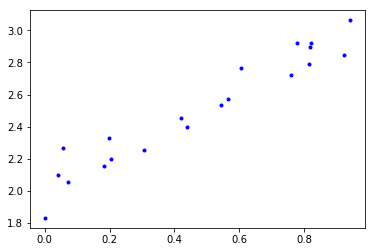

In [16]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [21]:
from tensorflow.keras.layers import Layer

In [22]:
# Build a custom layer for the linear regression model
class LinearLayer(Layer):
    
    def __init__(self):
        super(LinearLayer,self).__init__()
        self.m = self.add_weight(\
                                initializer = 'random_normal')
        self.b = self.add_weight(\
                                initializer = 'zeros')
    
    def call(self, inputs):
        return self.m * inputs + self.b
    
linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)

tf.Tensor(
[4.69979225e-03 2.11642105e-02 1.88313238e-03 1.45734465e-02
 1.13657480e-02 7.00186647e-05 1.95700061e-02 2.00838074e-02
 2.42774282e-02 2.10372601e-02 1.49225385e-03 2.11190414e-02
 1.55877154e-02 1.40366070e-02 5.11538843e-03 5.25658391e-03
 1.08661111e-02 1.08597311e-03 2.38320325e-02 7.87434541e-03], shape=(20,), dtype=float32)
[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0258407>, <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>]


#### Define the loss function

In [23]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.3169823


#### Train and plot the model

In [24]:
# Implement a gradient descent training loop for the linear regression model
learning_rate = 0.5
steps = 25

for i in range(steps):
    with tf.GradientTape() as tape:
        predictions = linear_regression(x_train)
        loss = SquaredError(predictions,y_train)
        
    gradients = tape.gradient(loss,linear_regression.trainable_variables)
    
    linear_regression.m.assign_sub(learning_rate * gradients[0])
    linear_regression.b.assign_sub(learning_rate * gradients[1])
    
    print("Step %d, Loss %f" % (i, loss.numpy()))


Step 0, Loss 6.316982
Step 1, Loss 0.384427
Step 2, Loss 0.030745
Step 3, Loss 0.009659
Step 4, Loss 0.008401
Step 5, Loss 0.008325
Step 6, Loss 0.008320
Step 7, Loss 0.008319
Step 8, Loss 0.008319
Step 9, Loss 0.008319
Step 10, Loss 0.008318
Step 11, Loss 0.008318
Step 12, Loss 0.008318
Step 13, Loss 0.008318
Step 14, Loss 0.008317
Step 15, Loss 0.008317
Step 16, Loss 0.008317
Step 17, Loss 0.008317
Step 18, Loss 0.008317
Step 19, Loss 0.008317
Step 20, Loss 0.008317
Step 21, Loss 0.008317
Step 22, Loss 0.008317
Step 23, Loss 0.008317
Step 24, Loss 0.008317


m:1,  trained m:1.0486302375793457
b:2,  trained b:2.0061354637145996


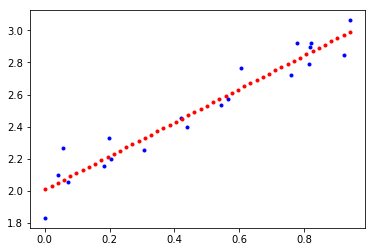

In [27]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [12]:
# Define the custom layers and model
class MyLayer(Layer):
    def __init__(self, units):
        super(MyLayer,self).__init__()
        self.units = units
        
    def build(self,input_shape):
        self.w = self.add_weight(shape = (input_shape[-1], self.units),
                                initializer= 'random_normal',
                                name = 'kernel')
        self.b = self.add_weight(shape = (self.units,), 
                                initializer= 'zeros',
                                name = 'bias')
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs,rate = self.rate)
    
    
class MyModel(Model):

    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [13]:
model = MyModel(64, 64, 46)
print(model(tf.ones((1,10000))))
model.summary()

tf.Tensor(
[[0.0090154  0.05713783 0.00656914 0.00550095 0.00774983 0.02509638
  0.0870337  0.0045437  0.03604421 0.01467754 0.00251735 0.0158778
  0.00845477 0.01066345 0.03170589 0.00572502 0.02026192 0.00654037
  0.05211061 0.00598256 0.01106275 0.03230668 0.0598026  0.03190329
  0.01086991 0.0072546  0.01340531 0.00649597 0.02829964 0.01140025
  0.01057537 0.00890442 0.03155675 0.01706091 0.07435096 0.02692217
  0.03055704 0.03202375 0.02044559 0.00664454 0.0291609  0.00576145
  0.00808927 0.01472831 0.0341243  0.02308489]], shape=(1, 46), dtype=float32)
Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_3 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_2 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_4 (MyLayer

#### Load the reuters dataset and define the class_names 

In [14]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


In [15]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [16]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [17]:
# Print the first data example sentence
print(text_news)


? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


#### Preprocess the data

In [18]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [19]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [20]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [1]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # training loop:
    for x,y in train_dataset:
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
        # compute current loss:
        epoch_loss_avg(loss_value)
        epoch_accuracy(to_categorical(y),model(x))
        
    # end epoch:
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print("Epoch {:03d}: Loss {:.3f}, Accuracy: {:.3f}".format(epoch, epoch_loss_avg.result(), epoch_accuracy.result()))
    print("Duration :{:.3f}".format(time.time() - start_time))

NameError: name 'time' is not defined

#### Evaluate the model

In [ ]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [ ]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

#### Plot the learning curves

In [ ]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [ ]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [28]:
# Initialize a new model
model = MyModel(64, 64, 46)


#### Redefine the grad function using the @tf.function decorator

In [30]:
# Use the @tf.function decorator
@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


#### Train the model

In [31]:
# Re-run the training loop
from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
train_dataset = train_dataset.batch(32)

train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # training loop:
    for x,y in train_dataset:
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
        # compute current loss:
        epoch_loss_avg(loss_value)
        epoch_accuracy(to_categorical(y),model(x))
        
    # end epoch:
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print("Epoch {:03d}: Loss {:.3f}, Accuracy: {:.3f}".format(epoch, epoch_loss_avg.result(), epoch_accuracy.result()))
print("Duration :{:.3f}".format(time.time() - start_time))



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 000: Loss 2.420, Accuracy: 0.565
Epoch 001: Loss 1.948, Accuracy: 0.649
Epoch 002: Loss 1.846, Accuracy: 0.666
Epoch 003: Loss 1.805, Accuracy: 0.676
Epoch 004: Loss 1.774, Accuracy: 0.685
Epoch 005: Loss 1.762, Accuracy: 0.690
Epoch 006: Loss 1.742, Accuracy: 0.697
Epoch 007: Loss 1.713, Accuracy: 0.697
Epoch 008: Loss 1.720, Accuracy: 0.699
Epoch 009: Loss 1.709, Accuracy: 0.704
Duration :197.942


#### Print the autograph code

In [ ]:
# Use tf.autograph.to_code to see the generated code
tf.autograph.to_code()
